# ML4T PIPELINE - NOTEBOOK 2: ALPHA FACTORY

- Goal: Engineer predictive features from price data
- Input: market_prices.h5 (from Notebook 1)
- Output: alpha_features.h5 (ready for ML training)

## 02 Alpha Factory: Feature Engineering

This notebook implements the **Alpha Factory** from the ML4T framework.

**What we do:**
1. Load clean OHLCV data from Notebook 1
2. Calculate Technical Indicators (Momentum, Volatility)
3. Calculate Forward Returns (our prediction targets)
4. Create the target variable (Y) for supervised learning
5. Export features for ML training

**Output:** `alpha_features.h5` → Ready for Model Training (Notebook 3)

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import warnings
warnings.filterwarnings('ignore')

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("darkgrid")
plt.rcParams['figure.figsize'] = (14, 8)

In [2]:
# Google Colab Drive mounting (comment out if running locally)
try:
    from google.colab import drive
    drive.mount('/content/drive')
    DRIVE_PATH = Path('/content/drive/MyDrive/ML4T_Pipeline')
    print("✓ Google Drive mounted successfully")
except:
    DRIVE_PATH = Path('./data')
    print("✓ Running locally - using ./data directory")

Mounted at /content/drive
✓ Google Drive mounted successfully


## 2. Load Market Data

In [3]:
# Load the data we created in Notebook 1
input_file = DRIVE_PATH / 'market_prices.h5'

print(f"Loading data from: {input_file}")
market_data = pd.read_hdf(input_file, key='prices')

print(f"\n✓ Data loaded successfully")
print(f"  Shape: {market_data.shape}")
print(f"  Date range: {market_data.index.get_level_values('Date').min()} to {market_data.index.get_level_values('Date').max()}")
print(f"  Tickers: {market_data.index.get_level_values('ticker').nunique()}")

print("\nSample data:")
print(market_data.head())

Loading data from: /content/drive/MyDrive/ML4T_Pipeline/market_prices.h5

✓ Data loaded successfully
  Shape: (24144, 5)
  Date range: 2016-01-04 00:00:00 to 2023-12-29 00:00:00
  Tickers: 12

Sample data:
                       close       high        low       open     volume
Date       ticker                                                       
2016-01-04 AAPL    23.753155  23.757665  22.997834  23.135370  270597600
           AMZN    31.849501  32.886002  31.375500  32.814499  186290000
           BAC     13.196471  13.244662  13.051896  13.212535  114888000
           CVX     57.923439  58.744865  57.088977  58.366747   11397300
           GOOGL   37.687241  37.824206  37.096701  37.824206   67382000


## 3. Feature Engineering Functions

### 3.1 Momentum Indicators

In [4]:
def calculate_rsi(prices, period=14):
    """
    Calculate Relative Strength Index (RSI)

    RSI measures momentum on a 0-100 scale:
    - RSI > 70: Overbought (potential sell signal)
    - RSI < 30: Oversold (potential buy signal)
    """
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=period).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=period).mean()

    rs = gain / loss
    rsi = 100 - (100 / (1 + rs))
    return rsi

In [5]:
def calculate_macd(prices, fast=12, slow=26, signal=9):
    """
    Calculate MACD (Moving Average Convergence Divergence)

    MACD shows trend strength and direction:
    - MACD > Signal: Bullish
    - MACD < Signal: Bearish
    """
    ema_fast = prices.ewm(span=fast, adjust=False).mean()
    ema_slow = prices.ewm(span=slow, adjust=False).mean()

    macd = ema_fast - ema_slow
    signal_line = macd.ewm(span=signal, adjust=False).mean()
    macd_histogram = macd - signal_line

    return macd, signal_line, macd_histogram

In [6]:
def calculate_momentum_features(df):
    """Calculate all momentum-based features"""
    print("\n" + "="*60)
    print("Calculating Momentum Features...")
    print("="*60)

    features = pd.DataFrame(index=df.index)

    # Calculate for each ticker separately
    for ticker in df.index.get_level_values('ticker').unique():
        ticker_data = df.xs(ticker, level='ticker')
        close = ticker_data['close']

        # RSI (14-day)
        features.loc[(slice(None), ticker), 'rsi_14'] = calculate_rsi(close, 14).values

        # MACD
        macd, macd_signal, macd_hist = calculate_macd(close)
        features.loc[(slice(None), ticker), 'macd'] = macd.values
        features.loc[(slice(None), ticker), 'macd_signal'] = macd_signal.values
        features.loc[(slice(None), ticker), 'macd_hist'] = macd_hist.values

        # Rate of Change (ROC) - momentum indicator
        features.loc[(slice(None), ticker), 'roc_10'] = close.pct_change(10).values * 100
        features.loc[(slice(None), ticker), 'roc_21'] = close.pct_change(21).values * 100

    print(f"✓ Created {len([c for c in features.columns if 'rsi' in c or 'macd' in c or 'roc' in c])} momentum features")
    return features

### 3.2 Volatility Indicators

In [7]:
def calculate_bollinger_bands(prices, period=20, num_std=2):
    """
    Calculate Bollinger Bands

    Bollinger Bands measure volatility:
    - Price near upper band: Potentially overbought
    - Price near lower band: Potentially oversold
    - Band width: Volatility measure
    """
    sma = prices.rolling(window=period).mean()
    std = prices.rolling(window=period).std()

    upper_band = sma + (std * num_std)
    lower_band = sma - (std * num_std)

    # %B indicator: where price is within the bands
    percent_b = (prices - lower_band) / (upper_band - lower_band)

    # Bandwidth: normalized band width
    bandwidth = (upper_band - lower_band) / sma

    return upper_band, lower_band, percent_b, bandwidth

In [8]:
def calculate_atr(high, low, close, period=14):
    """
    Calculate Average True Range (ATR)

    ATR measures volatility (absolute price movement)
    - High ATR: High volatility
    - Low ATR: Low volatility
    """
    high_low = high - low
    high_close = np.abs(high - close.shift())
    low_close = np.abs(low - close.shift())

    true_range = pd.concat([high_low, high_close, low_close], axis=1).max(axis=1)
    atr = true_range.rolling(window=period).mean()

    return atr

In [9]:
def calculate_volatility_features(df):
    """Calculate all volatility-based features"""
    print("\n" + "="*60)
    print("Calculating Volatility Features...")
    print("="*60)

    features = pd.DataFrame(index=df.index)

    for ticker in df.index.get_level_values('ticker').unique():
        ticker_data = df.xs(ticker, level='ticker')
        close = ticker_data['close']
        high = ticker_data['high']
        low = ticker_data['low']

        # Bollinger Bands
        bb_upper, bb_lower, bb_percent, bb_width = calculate_bollinger_bands(close)
        features.loc[(slice(None), ticker), 'bb_upper'] = bb_upper.values
        features.loc[(slice(None), ticker), 'bb_lower'] = bb_lower.values
        features.loc[(slice(None), ticker), 'bb_percent'] = bb_percent.values
        features.loc[(slice(None), ticker), 'bb_width'] = bb_width.values

        # ATR
        features.loc[(slice(None), ticker), 'atr_14'] = calculate_atr(high, low, close, 14).values

        # Historical Volatility (21-day rolling std of returns)
        returns = close.pct_change()
        features.loc[(slice(None), ticker), 'volatility_21'] = returns.rolling(21).std().values * np.sqrt(252)

    print(f"✓ Created {len([c for c in features.columns if 'bb_' in c or 'atr' in c or 'volatility' in c])} volatility features")
    return features

### 3.3 Return Calculations

In [10]:
def calculate_returns(df):
    """
    Calculate forward returns (our prediction targets)

    CRITICAL: We shift returns BACKWARDS to create forward-looking targets.
    This ensures no lookahead bias.
    """
    print("\n" + "="*60)
    print("Calculating Returns...")
    print("="*60)

    features = pd.DataFrame(index=df.index)

    for ticker in df.index.get_level_values('ticker').unique():
        ticker_data = df.xs(ticker, level='ticker')
        close = ticker_data['close']

        # Historical returns (for features)
        features.loc[(slice(None), ticker), 'return_1d'] = close.pct_change(1).values
        features.loc[(slice(None), ticker), 'return_5d'] = close.pct_change(5).values
        features.loc[(slice(None), ticker), 'return_21d'] = close.pct_change(21).values

        # Forward returns (our TARGET - what we want to predict)
        # SHIFT BACKWARD: shift(-5) means "5 days into the future"
        features.loc[(slice(None), ticker), 'forward_return_5d'] = close.pct_change(5).shift(-5).values
        features.loc[(slice(None), ticker), 'forward_return_21d'] = close.pct_change(21).shift(-21).values

    print(f"✓ Created {len([c for c in features.columns if 'return' in c])} return features")
    print(f"  - Historical returns: return_1d, return_5d, return_21d")
    print(f"  - Forward returns (TARGETS): forward_return_5d, forward_return_21d")

    return features

### 3.4 Volume Features

In [11]:
def calculate_volume_features(df):
    """Calculate volume-based features"""
    print("\n" + "="*60)
    print("Calculating Volume Features...")
    print("="*60)

    features = pd.DataFrame(index=df.index)

    for ticker in df.index.get_level_values('ticker').unique():
        ticker_data = df.xs(ticker, level='ticker')
        volume = ticker_data['volume']
        close = ticker_data['close']

        # Volume moving averages
        features.loc[(slice(None), ticker), 'volume_sma_20'] = volume.rolling(20).mean().values

        # Volume ratio (current / average)
        features.loc[(slice(None), ticker), 'volume_ratio'] = (volume / volume.rolling(20).mean()).values

        # Dollar volume (price * volume)
        features.loc[(slice(None), ticker), 'dollar_volume'] = (close * volume).values

        # Volume rate of change
        features.loc[(slice(None), ticker), 'volume_roc_5'] = volume.pct_change(5).values

    print(f"✓ Created {len([c for c in features.columns if 'volume' in c])} volume features")
    return features

## 4. Execute Feature Engineering Pipeline

In [14]:
print("FEATURE ENGINEERING PIPELINE")

# Calculate all feature groups
momentum_features = calculate_momentum_features(market_data)
volatility_features = calculate_volatility_features(market_data)
return_features = calculate_returns(market_data)
volume_features = calculate_volume_features(market_data)

# Combine all features
alpha_features = pd.concat([
    market_data,
    momentum_features,
    volatility_features,
    return_features,
    volume_features
], axis=1)

print(f"\n{'-'*60}")
print(f"✓ Feature engineering complete!")
print(f"  Total features: {len(alpha_features.columns)}")
print(f"  Total rows: {len(alpha_features):,}")

FEATURE ENGINEERING PIPELINE

Calculating Momentum Features...
✓ Created 6 momentum features

Calculating Volatility Features...
✓ Created 6 volatility features

Calculating Returns...
✓ Created 5 return features
  - Historical returns: return_1d, return_5d, return_21d
  - Forward returns (TARGETS): forward_return_5d, forward_return_21d

Calculating Volume Features...
✓ Created 4 volume features

------------------------------------------------------------
✓ Feature engineering complete!
  Total features: 26
  Total rows: 24,144


## 5. Create Target Variable

In [15]:
def create_target_variable(df, target_col='forward_return_5d', threshold=0.0):
    """
    Create binary classification target:
    - 1 if forward return > threshold (UP/BUY)
    - 0 if forward return <= threshold (DOWN/SELL)

    Args:
        df: DataFrame with forward_return column
        target_col: Name of forward return column to use
        threshold: Return threshold for classification (default 0%)
    """
    print("\n" + "="*60)
    print("Creating Target Variable (Y)")
    print("="*60)

    # Create binary target
    df['target'] = (df[target_col] > threshold).astype(int)

    # Statistics
    target_counts = df['target'].value_counts()
    total = len(df.dropna(subset=['target']))

    print(f"\nTarget Variable: '{target_col}' > {threshold:.2%}")
    print(f"\nClass Distribution:")
    print(f"  Class 0 (DOWN/SELL): {target_counts.get(0, 0):,} ({target_counts.get(0, 0)/total:.1%})")
    print(f"  Class 1 (UP/BUY):    {target_counts.get(1, 0):,} ({target_counts.get(1, 0)/total:.1%})")
    print(f"  Total: {total:,}")

    return df

# Create target using 5-day forward returns
alpha_features = create_target_variable(alpha_features, target_col='forward_return_5d', threshold=0.0)


Creating Target Variable (Y)

Target Variable: 'forward_return_5d' > 0.00%

Class Distribution:
  Class 0 (DOWN/SELL): 10,790 (44.7%)
  Class 1 (UP/BUY):    13,354 (55.3%)
  Total: 24,144


## 6. Data Cleaning & Quality Checks

In [16]:
print("Data Cleaning...")
print("-"*60)

# Check for infinite values
inf_mask = np.isinf(alpha_features.select_dtypes(include=[np.number])).any(axis=1)
print(f"\nRows with infinite values: {inf_mask.sum()}")
if inf_mask.sum() > 0:
    alpha_features = alpha_features[~inf_mask]
    print(f"✓ Removed {inf_mask.sum()} rows with infinite values")

# Report missing values per column
missing_counts = alpha_features.isnull().sum().sort_values(ascending=False)
missing_pct = (missing_counts / len(alpha_features) * 100).round(2)

print(f"\nMissing Values by Feature (top 10):")
missing_df = pd.DataFrame({
    'Missing Count': missing_counts.head(10),
    'Percentage': missing_pct.head(10).astype(str) + '%'
})
print(missing_df)

# Drop rows where target is NaN (last 21 days have no forward returns)
original_len = len(alpha_features)
alpha_features = alpha_features.dropna(subset=['target'])
dropped = original_len - len(alpha_features)

print(f"\n✓ Dropped {dropped} rows with missing target")
print(f"✓ Final dataset: {len(alpha_features):,} rows")

Data Cleaning...
------------------------------------------------------------

Rows with infinite values: 0

Missing Values by Feature (top 10):
                    Missing Count Percentage
roc_21                        252      1.04%
return_21d                    252      1.04%
volatility_21                 252      1.04%
forward_return_21d            252      1.04%
bb_lower                      228      0.94%
volume_sma_20                 228      0.94%
bb_width                      228      0.94%
bb_upper                      228      0.94%
bb_percent                    228      0.94%
volume_ratio                  228      0.94%

✓ Dropped 0 rows with missing target
✓ Final dataset: 24,144 rows


## 7. Feature Summary Statistics

In [17]:
def feature_summary(df):
    """Generate summary statistics for features"""
    print("\n" + "="*60)
    print("FEATURE SUMMARY STATISTICS")
    print("="*60)

    # Separate features by category
    momentum_cols = [c for c in df.columns if any(x in c for x in ['rsi', 'macd', 'roc'])]
    volatility_cols = [c for c in df.columns if any(x in c for x in ['bb_', 'atr', 'volatility'])]
    return_cols = [c for c in df.columns if 'return' in c]
    volume_cols = [c for c in df.columns if 'volume' in c]

    print(f"\nFeature Categories:")
    print(f"  Momentum: {len(momentum_cols)} features")
    print(f"  Volatility: {len(volatility_cols)} features")
    print(f"  Returns: {len(return_cols)} features")
    print(f"  Volume: {len(volume_cols)} features")
    print(f"  Price (OHLCV): 5 features")
    print(f"  Target: 1 feature")
    print(f"  Total: {len(df.columns)} features")

    # Sample statistics for key features
    key_features = ['rsi_14', 'macd', 'bb_percent', 'volatility_21', 'return_1d', 'forward_return_5d']
    existing_features = [f for f in key_features if f in df.columns]

    print(f"\nKey Feature Statistics:")
    print(df[existing_features].describe().round(4))

feature_summary(alpha_features)


FEATURE SUMMARY STATISTICS

Feature Categories:
  Momentum: 7 features
  Volatility: 6 features
  Returns: 5 features
  Volume: 5 features
  Price (OHLCV): 5 features
  Target: 1 feature
  Total: 27 features

Key Feature Statistics:
           rsi_14        macd  bb_percent  volatility_21   return_1d  \
count  23988.0000  24144.0000  23916.0000     23892.0000  24132.0000   
mean      53.8617      0.4142      0.5613         0.2741      0.0008   
std       17.2844      2.9622      0.3241         0.1689      0.0203   
min        1.3766    -25.2713     -0.4082         0.0442     -0.2212   
25%       41.4749     -0.4311      0.3033         0.1679     -0.0078   
50%       54.0357      0.2668      0.6044         0.2324      0.0007   
75%       66.6067      1.1914      0.8223         0.3244      0.0096   
max       99.1120     38.0679      1.4347         1.6849      0.2274   

       forward_return_5d  
count         24084.0000  
mean              0.0042  
std               0.0443  
min      

## 8. Visualizations


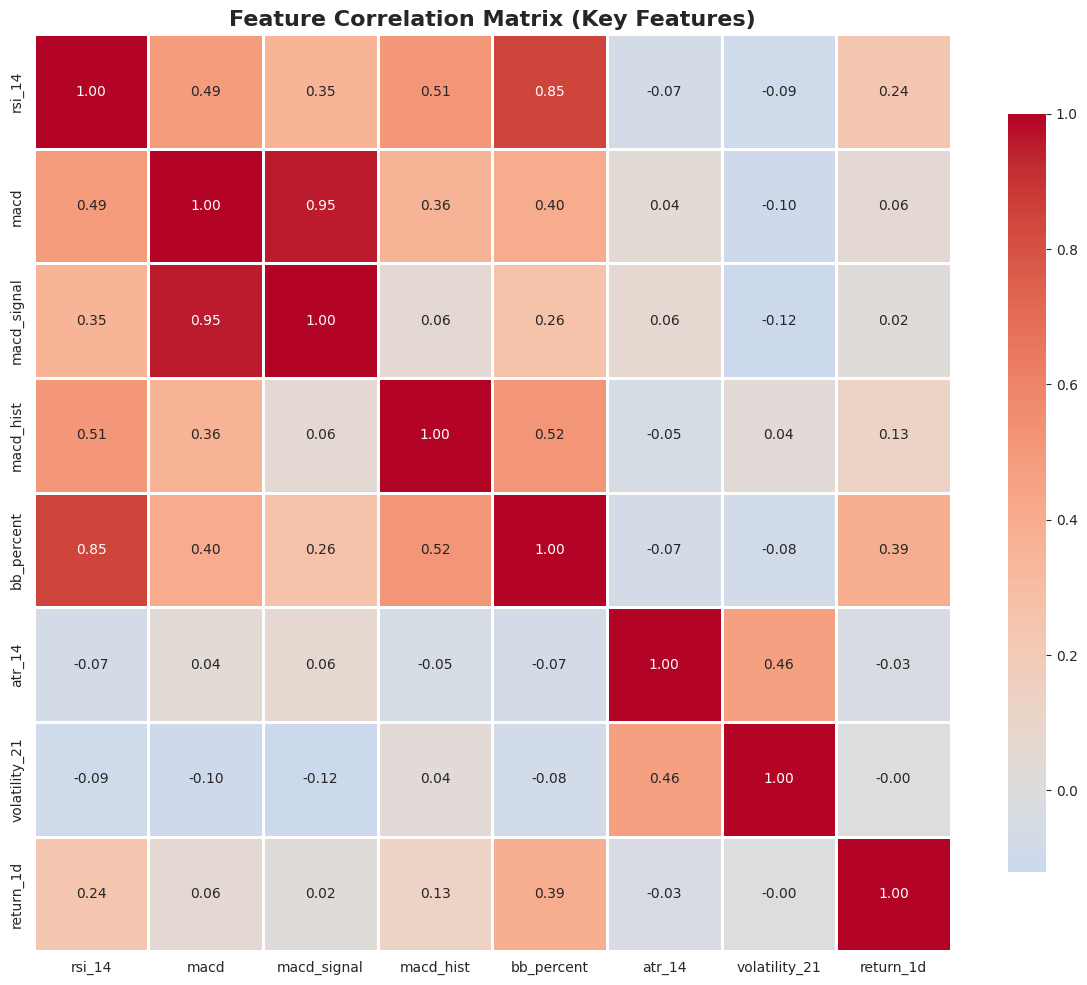

In [18]:
def plot_feature_correlation(df, sample_size=5000):
    """Plot correlation heatmap of features"""
    # Sample data for faster computation
    df_sample = df.sample(min(sample_size, len(df)), random_state=42)

    # Select numeric columns only (exclude target for now)
    feature_cols = [c for c in df_sample.columns if c != 'target' and df_sample[c].dtype in ['float64', 'int64']]

    # Calculate correlation (select subset of features for readability)
    key_features = [c for c in feature_cols if any(x in c for x in ['rsi', 'macd', 'bb_percent', 'volatility', 'return_1d', 'atr'])][:15]
    corr_matrix = df_sample[key_features].corr()

    fig, ax = plt.subplots(figsize=(12, 10))
    sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
                square=True, linewidths=1, cbar_kws={"shrink": 0.8}, ax=ax)
    ax.set_title('Feature Correlation Matrix (Key Features)', fontsize=16, fontweight='bold')
    plt.tight_layout()
    plt.show()

plot_feature_correlation(alpha_features)

### 8.2 Feature Distribution by Target Class

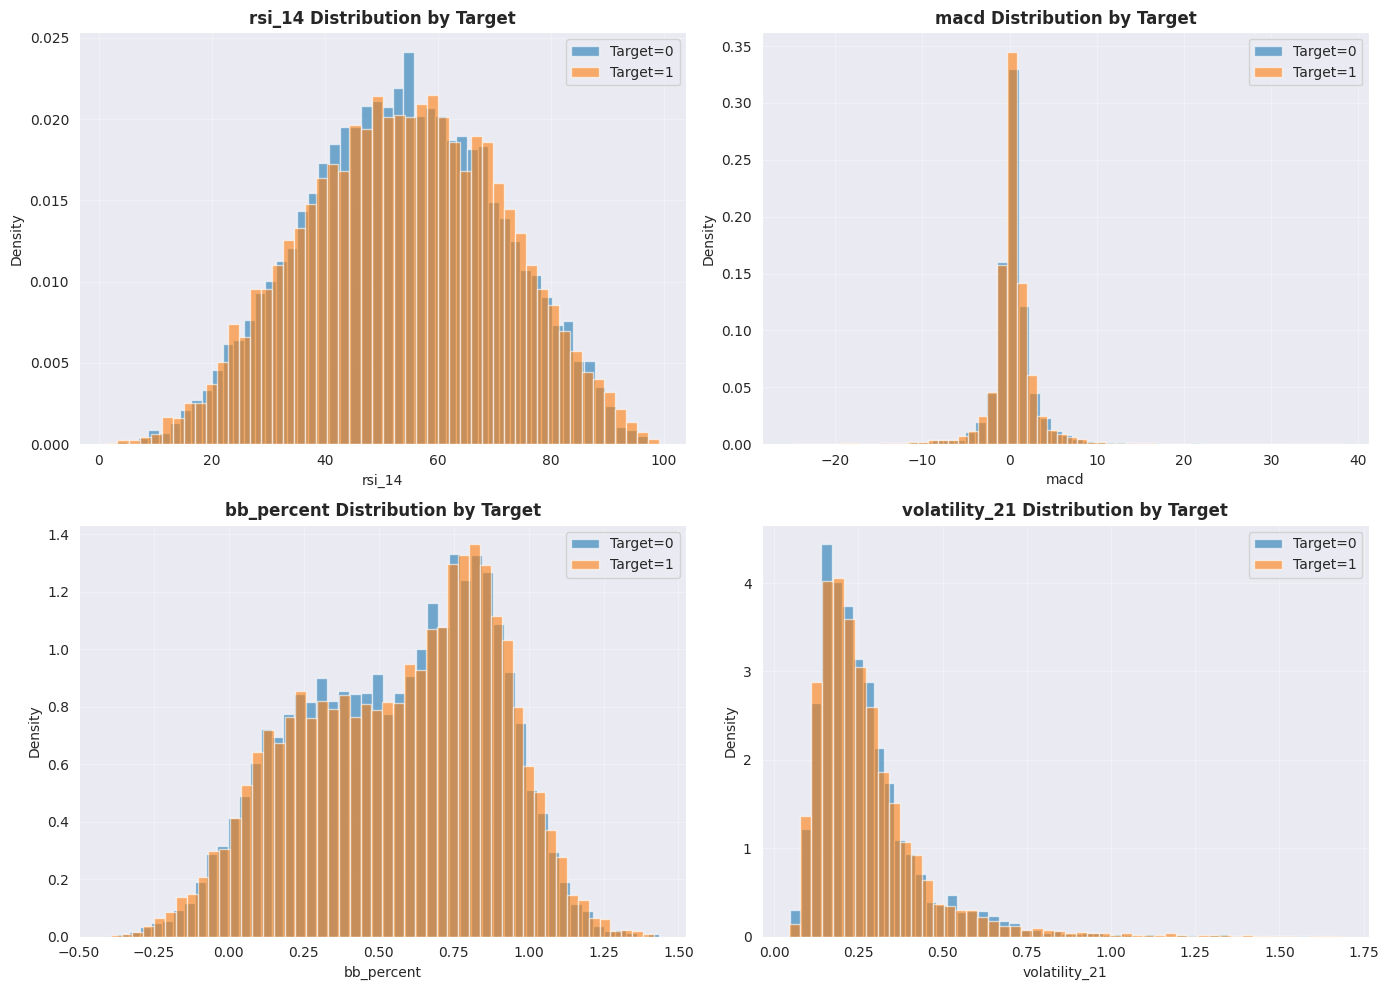

In [19]:
def plot_feature_distributions(df, features_to_plot=None):
    """Plot feature distributions by target class"""
    if features_to_plot is None:
        features_to_plot = ['rsi_14', 'macd', 'bb_percent', 'volatility_21']

    # Filter to existing features
    features_to_plot = [f for f in features_to_plot if f in df.columns]

    fig, axes = plt.subplots(2, 2, figsize=(14, 10))
    axes = axes.flatten()

    for idx, feature in enumerate(features_to_plot[:4]):
        ax = axes[idx]

        # Plot distributions for each target class
        for target_class in [0, 1]:
            data = df[df['target'] == target_class][feature].dropna()
            ax.hist(data, bins=50, alpha=0.6, label=f'Target={target_class}', density=True)

        ax.set_title(f'{feature} Distribution by Target', fontsize=12, fontweight='bold')
        ax.set_xlabel(feature)
        ax.set_ylabel('Density')
        ax.legend()
        ax.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

plot_feature_distributions(alpha_features)

### 8.3 Forward Returns Distribution

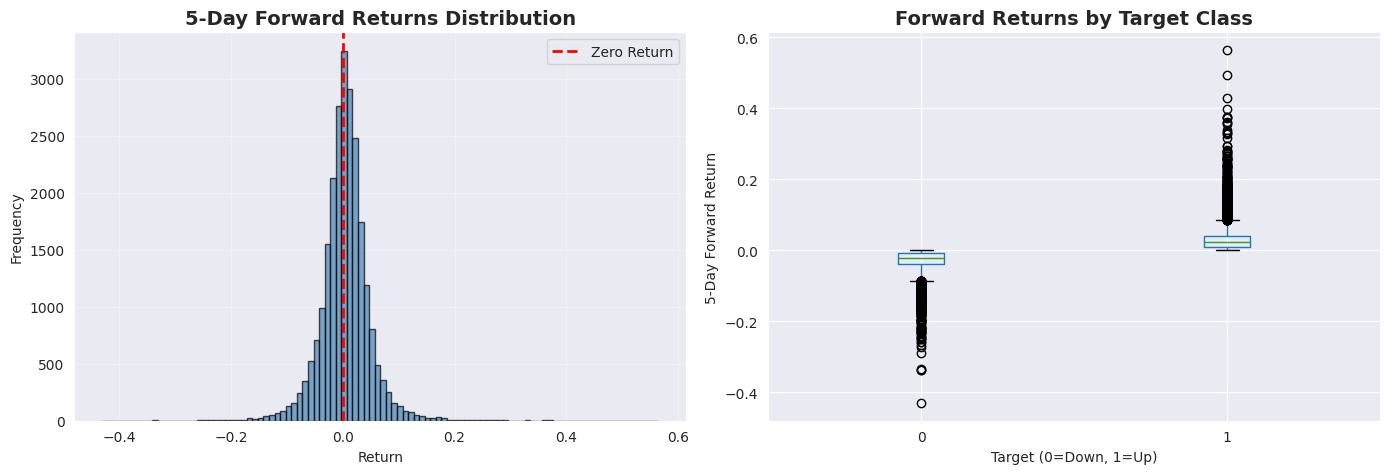


Forward Return Statistics:
          count      mean       std       min       25%       50%       75%  \
target                                                                        
0       10730.0 -0.029603  0.031086 -0.430459 -0.039561 -0.020492 -0.008824   
1       13354.0  0.031381  0.033300  0.000014  0.010613  0.022276  0.040864   

             max  
target            
0       0.000000  
1       0.564756  


In [20]:
def plot_forward_returns(df):
    """Visualize forward returns distribution"""
    fig, axes = plt.subplots(1, 2, figsize=(14, 5))

    # Histogram
    axes[0].hist(df['forward_return_5d'].dropna(), bins=100, alpha=0.7, color='steelblue', edgecolor='black')
    axes[0].axvline(x=0, color='red', linestyle='--', linewidth=2, label='Zero Return')
    axes[0].set_title('5-Day Forward Returns Distribution', fontsize=14, fontweight='bold')
    axes[0].set_xlabel('Return')
    axes[0].set_ylabel('Frequency')
    axes[0].legend()
    axes[0].grid(True, alpha=0.3)

    # Box plot by target class
    df_plot = df[['forward_return_5d', 'target']].dropna()
    df_plot.boxplot(column='forward_return_5d', by='target', ax=axes[1])
    axes[1].set_title('Forward Returns by Target Class', fontsize=14, fontweight='bold')
    axes[1].set_xlabel('Target (0=Down, 1=Up)')
    axes[1].set_ylabel('5-Day Forward Return')
    plt.suptitle('')  # Remove default title

    plt.tight_layout()
    plt.show()

    # Statistics
    print("\nForward Return Statistics:")
    print(df.groupby('target')['forward_return_5d'].describe())

plot_forward_returns(alpha_features)

### 8.4 Feature Importance Preview (Simple Analysis)

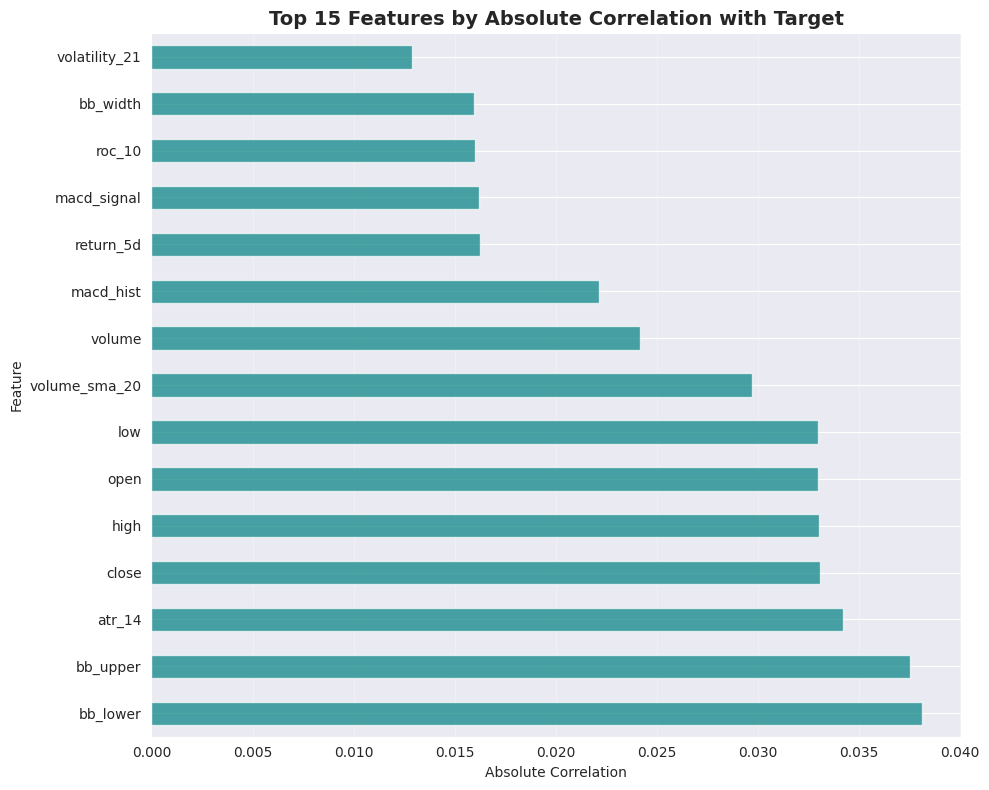


Top 10 Predictive Features (by correlation):
bb_lower         0.038123
bb_upper         0.037512
atr_14           0.034216
close            0.033083
high             0.033004
open             0.032963
low              0.032953
volume_sma_20    0.029688
volume           0.024156
macd_hist        0.022156
Name: target, dtype: float64


In [21]:
def plot_feature_target_correlation(df, top_n=15):
    """Show correlation between features and target"""
    # Calculate correlation with target
    numeric_cols = df.select_dtypes(include=[np.number]).columns
    feature_cols = [c for c in numeric_cols if c not in ['target', 'forward_return_5d', 'forward_return_21d']]

    correlations = df[feature_cols + ['target']].corr()['target'].drop('target').abs().sort_values(ascending=False)

    # Plot top N
    fig, ax = plt.subplots(figsize=(10, 8))
    correlations.head(top_n).plot(kind='barh', ax=ax, color='teal', alpha=0.7)
    ax.set_title(f'Top {top_n} Features by Absolute Correlation with Target', fontsize=14, fontweight='bold')
    ax.set_xlabel('Absolute Correlation')
    ax.set_ylabel('Feature')
    ax.grid(True, alpha=0.3, axis='x')
    plt.tight_layout()
    plt.show()

    print("\nTop 10 Predictive Features (by correlation):")
    print(correlations.head(10))

plot_feature_target_correlation(alpha_features)

## 9. Save Engineered Features

In [22]:
# Define output path
output_file = DRIVE_PATH / 'alpha_features.h5'

# Save to HDF5
print(f"\nSaving features to: {output_file}")
alpha_features.to_hdf(
    output_file,
    key='features',
    mode='w',
    format='table',
    complevel=9
)

print(f"✓ Features saved successfully")
print(f"  File size: {output_file.stat().st_size / 1024 / 1024:.2f} MB")


Saving features to: /content/drive/MyDrive/ML4T_Pipeline/alpha_features.h5
✓ Features saved successfully
  File size: 3.91 MB


## 10. Verification: Reload Data

In [23]:
# Verify we can reload
print("\nVerifying saved data...")
reloaded = pd.read_hdf(output_file, key='features')

print(f"✓ Successfully reloaded features")
print(f"  Shape: {reloaded.shape}")
print(f"  Matches original: {reloaded.shape == alpha_features.shape}")

print("\nFeature columns:")
print(list(reloaded.columns))


Verifying saved data...
✓ Successfully reloaded features
  Shape: (24144, 27)
  Matches original: True

Feature columns:
['close', 'high', 'low', 'open', 'volume', 'rsi_14', 'macd', 'macd_signal', 'macd_hist', 'roc_10', 'roc_21', 'bb_upper', 'bb_lower', 'bb_percent', 'bb_width', 'atr_14', 'volatility_21', 'return_1d', 'return_5d', 'return_21d', 'forward_return_5d', 'forward_return_21d', 'volume_sma_20', 'volume_ratio', 'dollar_volume', 'volume_roc_5', 'target']


## 11. Summary & Next Steps

In [24]:
print("NOTEBOOK 2 COMPLETE: ALPHA FACTORY")
print(f"{'-'*60}")
print(f"\n✓ Loaded market data from Notebook 1")
print(f"✓ Calculated {len(alpha_features.columns)} features:")
print(f"   - Momentum: RSI, MACD, ROC")
print(f"   - Volatility: Bollinger Bands, ATR, Historical Vol")
print(f"   - Returns: Historical + Forward-looking")
print(f"   - Volume: Volume ratios, dollar volume")
print(f"✓ Created target variable (binary classification)")
print(f"✓ Saved to: {output_file}")

print(f"\n Final Dataset:")
print(f"   - Tickers: {alpha_features.index.get_level_values('ticker').nunique()}")
print(f"   - Date Range: {alpha_features.index.get_level_values('Date').min().date()} to {alpha_features.index.get_level_values('Date').max().date()}")
print(f"   - Total Rows: {len(alpha_features):,}")
print(f"   - Total Features: {len(alpha_features.columns)}")
print(f"   - Target Distribution: {alpha_features['target'].value_counts().to_dict()}")

print(f"\n Next: Open Notebook 3 (03_Model_Training.ipynb)")
print(f"   Input: alpha_features.h5")
print(f"   Output: trained_model.joblib + predictions.csv")

NOTEBOOK 2 COMPLETE: ALPHA FACTORY
------------------------------------------------------------

✓ Loaded market data from Notebook 1
✓ Calculated 27 features:
   - Momentum: RSI, MACD, ROC
   - Volatility: Bollinger Bands, ATR, Historical Vol
   - Returns: Historical + Forward-looking
   - Volume: Volume ratios, dollar volume
✓ Created target variable (binary classification)
✓ Saved to: /content/drive/MyDrive/ML4T_Pipeline/alpha_features.h5

 Final Dataset:
   - Tickers: 12
   - Date Range: 2016-01-04 to 2023-12-29
   - Total Rows: 24,144
   - Total Features: 27
   - Target Distribution: {1: 13354, 0: 10790}

 Next: Open Notebook 3 (03_Model_Training.ipynb)
   Input: alpha_features.h5
   Output: trained_model.joblib + predictions.csv
